In [3]:
from sklearn.linear_model import Ridge
import numpy as np
import time
import string
# from copy import copy
import pickle
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import IPython
import itertools
from collections import defaultdict
from sklearn.cross_validation import cross_val_score
import sklearn.metrics

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Подготовка субтитров

In [15]:
umlautDictionary = {u'Ä': 'Ae', u'Ö': 'Oe', u'Ü': 'Ue',  u'ä': 'ae', u'ö': 'oe', u'ü': 'ue', u'ß':u'ss'}
with open('forrest.srt') as f_srt:
    text = f_srt.read()
    text = text.decode('utf-8')
    
for item, val in umlautDictionary.iteritems():
    text = text.replace(item, val)

text = text.split('\r\n')
text = filter(lambda s: s != u'', text)
print text[:5]

[u'1', u'00:03:10,160 --> 00:03:14,631', u'Hallo. Mein Name ist Forrest.', u'Forrest Gump.', u'2']


In [16]:
timestamps = filter(lambda s: '>' in s, text)
number_indecies = filter(lambda s: text[s].isdigit(), range(len(text)))
timestamp_indecies = filter(lambda s: text[s] in timestamps, range(len(text)))
text_indecies = filter(lambda s: not (s in number_indecies or s in timestamp_indecies) , range(len(text)))

assert len(timestamps) == len(number_indecies)

In [17]:
def timestamp_str_to_seconds(timestamp):
    
    def time_to_sec(time):
        time = time.split(':')
        return float(time[0]) * 60 * 60 + float(time[1]) * 60 + float(time[2])
    
    time_start, time_end = timestamp.split(' --> ')
    return time_to_sec(time_start), time_to_sec(time_end)

In [18]:
parsed_timestamps = map(lambda s: [time.strptime(s[:12], '%H:%M:%S,%f'), 
                            time.strptime(s[17:], '%H:%M:%S,%f')], timestamps)
print timestamps[0]
print parsed_timestamps[0][0].tm_hour, parsed_timestamps[0][0].tm_min, parsed_timestamps[0][0].tm_sec
print parsed_timestamps[0][1].tm_hour, parsed_timestamps[0][1].tm_min, parsed_timestamps[0][1].tm_sec

00:03:10,160 --> 00:03:14,631
0 3 10
0 3 14


In [19]:
timestamps = map(lambda s: s.replace(',', '.'), timestamps)
seconds = map(timestamp_str_to_seconds, timestamps)
print seconds[:5]

[(190.16, 194.631), (200.32, 202.151), (204.48, 208.837), (208.92000000000002, 213.63), (216.0, 219.31)]


In [21]:
table = string.maketrans("", "")
parsed_phrases = []

for i, phrase in enumerate(text):
    if i not in text_indecies:
        continue
    
    phrase = phrase.encode('utf-8')
    phrase = phrase.translate(table,string.punctuation)
    phrase = phrase.translate(table, string.digits)
    phrase = phrase.lower()
    phrase = phrase.split(' ')
    phrase = filter(lambda s: s != u'', phrase)
    
    if phrase != []:
        if i - 1 in text_indecies:
            parsed_phrases[-1].extend(phrase)
        else:
            parsed_phrases.append(phrase)

In [36]:
with open('subtitles_by_word_first_15_min.txt', 'wb')as f:
    for phrase in srt.text:
        for word in phrase:
            f.write(word + '\n')

In [23]:
assert len(parsed_phrases) == len(timestamps) == len(number_indecies)

In [24]:
srt = pd.DataFrame(columns=['start', 'end', 'text'])
srt.start = [seconds[i][0] for i in range(len(seconds))]
srt.end = [seconds[i][1] for i in range(len(seconds))]
srt.text = [parsed_phrases[i] for i in range(len(seconds))]

In [25]:
srt

,start,end,text
0,190.16,194.631,"[hallo, mein, name, ist, forrest, forrest, gump]"
1,200.32,202.151,"[moechten, sie, eine, praline]"
2,204.48,208.837,"[die, koennte, ich, pfundweise, essen]"
3,208.92,213.630,"[meine, mama, sagte, immer, das, leben, ist, w..."
4,216.00,219.310,"[man, weiss, nie, was, man, kriegt]"
5,225.60,228.353,"[das, muessen, ja, bequeme, schuhe, sein]"
6,228.44,233.230,"[ich, wette, damit, kann, man, den, ganzen, ta..."
7,235.72,240.032,"[ich, wuenschte, ich, haette, so, welche, mein..."
8,241.48,243.869,"[mama, sagte, immer, es, gibt, vieles]"
9,243.96,247.111,"[was, man, an, den, schuhen, einer, person, ab..."


# Удаление сцен

In [28]:
# http://www.nature.com/articles/sdata20143/tables/1

times_to_stay = [
'00:00:00.00 --> 00:21:32.12',
'00:24:13.24 --> 00:38:31.23', 
'00:38:58.20 --> 00:57:19.22', 
'00:59:31.17 --> 01:18:14.00', 
'01:20:24.16 --> 01:34:18.06', 
'01:37:14.19 --> 01:41:30.19',
'01:42:49.19 --> 02:09:51.17']

times_to_stay = map(timestamp_str_to_seconds, times_to_stay)
times_to_stay

[(0.0, 1292.12),
 (1453.24, 2311.23),
 (2338.2, 3439.22),
 (3571.17, 4694.0),
 (4824.16, 5658.06),
 (5834.19, 6090.19),
 (6169.19, 7791.17)]

In [29]:
def is_in_stimulus(record, times_to_stay=times_to_stay):
    for time_moment_start, time_moment_end in times_to_stay:
        if time_moment_start <= record.start and time_moment_end >= record.end:
            return True
        
    return False

In [30]:
srt = srt.ix[[i for i in range(len(srt)) if is_in_stimulus(srt.ix[i])]]

In [31]:
srt

,start,end,text
0,190.16,194.631,"[hallo, mein, name, ist, forrest, forrest, gump]"
1,200.32,202.151,"[moechten, sie, eine, praline]"
2,204.48,208.837,"[die, koennte, ich, pfundweise, essen]"
3,208.92,213.630,"[meine, mama, sagte, immer, das, leben, ist, w..."
4,216.00,219.310,"[man, weiss, nie, was, man, kriegt]"
5,225.60,228.353,"[das, muessen, ja, bequeme, schuhe, sein]"
6,228.44,233.230,"[ich, wette, damit, kann, man, den, ganzen, ta..."
7,235.72,240.032,"[ich, wuenschte, ich, haette, so, welche, mein..."
8,241.48,243.869,"[mama, sagte, immer, es, gibt, vieles]"
9,243.96,247.111,"[was, man, an, den, schuhen, einer, person, ab..."


In [32]:
srt.to_csv('german_srt_cut.csv')

# Разбиение аудио на сегменты

In [75]:
import pydub

# Разбиение на сегменты

In [72]:
# http://www.nature.com/articles/sdata20143/#f2

segments_time = [0., 902., 882., 876., 976., 924., 878., 1084., 675.]
total_segments_time = np.cumsum(np.array(segments_time))
total_segments_time

array([    0.,   902.,  1784.,  2660.,  3636.,  4560.,  5438.,  6522.,
        7197.])

In [65]:
srt['duration'] = srt.end - srt.start
srt.head()

,start,end,text,duration
0,190.16,194.631,"[hallo, mein, name, ist, forrest, forrest, gump]",4.471
1,200.32,202.151,"[moechten, sie, eine, praline]",1.831
2,204.48,208.837,"[die, koennte, ich, pfundweise, essen]",4.357
3,208.92,213.630,"[meine, mama, sagte, immer, das, leben, ist, w...",4.710
4,216.00,219.310,"[man, weiss, nie, was, man, kriegt]",3.310


In [67]:
segments = []

for i in range(1, len(total_segments_time)):
    segments_pd = srt.ix[srt.end < total_segments_time[i]]
    segments_pd = segments_pd.ix[segments_pd.start > total_segments_time[i-1]]
    segments.append(segments_pd)

In [71]:
for i, segment in enumerate(segments):
    with open('segment_{}.txt'.format(i + 1), 'wb') as f:
        for phrase in segment.text:
            for word in phrase:
                f.write(word + '\n')

# Подготовка данных МРТ

In [14]:
with open('forrest_align_by_word_first_15_min.txt', 'r') as f:
    records = f.readlines()
    
records = map(lambda s: s.strip().split(), records)
records = map(lambda s: [float(s[1]) + 180., float(s[2]) + 180., s[3][1 : -1]], records)
records[:5]

[[180.0, 189.04, 'hallo'],
 [189.04, 190.96, 'mein'],
 [190.96, 191.4, 'name'],
 [191.4, 191.64, 'ist'],
 [191.64, 192.36, 'forrest']]

In [15]:
record_pd = pd.DataFrame(columns=['start', 'end', 'word'], data=records)

In [43]:
mri = nib.load('bold.nii.gz')
mri_data= mri.get_data()
mri_data.shape

(160, 160, 36, 451)

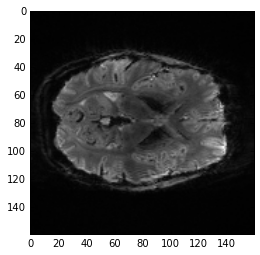

KeyboardInterrupt: 

In [44]:
for i in range(20):
    IPython.display.clear_output()
    plt.imshow(mri_data[:, :, 16, i], cmap='gray')
    plt.show()
    time.sleep(0.5)

In [17]:
with open('word2vec_german_sub_Forrest_Gump.pickle', 'rb') as f_dict:
    dictionary = pickle.load(f_dict)

In [18]:
def def_dict(word):
    if word in dictionary.keys():
        return dictionary[word]

In [19]:
record_pd['vector'] = map(def_dict, record_pd['word'])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  from ipykernel import kernelapp as app


In [20]:
record_pd.head()

,start,end,word,vector
0,180.00,189.04,hallo,"[-0.00216967, -0.0205193, 0.0924138, 0.187472,..."
1,189.04,190.96,mein,"[0.332542, -0.0170897, 0.127019, 0.117337, 0.0..."
2,190.96,191.40,name,"[-0.230506, 0.0665354, -0.15426, 0.465509, 0.0..."
3,191.40,191.64,ist,"[0.146284, -0.0737619, -0.0211892, -0.0542237,..."
4,191.64,192.36,forrest,"[0.0369523, -0.027655, -0.176746, -0.235293, -..."


In [ ]:
record_pd.to_csv('german_sub_1_segment.csv')

# Соединение данных МРТ и стимулов

In [2]:
record_pd = pd.read_csv('german_sub_1_segment.csv')

In [118]:
weights = defaultdict(list)
EPS = 0.1

In [119]:
record_pd = record_pd.dropna()

In [123]:
def get_ridge_weights(pairs_list, dta=record_pd):#, alpha=0.005):
    X = map(lambda ind: record_pd.ix[ind[0]].vector, pairs_list)
    y = np.array([pair[1] for pair in pairs_list])
    
    print 'r2 score: ', cross_val_score(Ridge(), X, y=y, scoring='r2').mean()
    
    ridge_regr = Ridge()
    ridge_regr.fit(X, y)
    
    #print sklearn.metrics.mean_squared_error(y, ridge_regr.predict(X))
    
    return ridge_regr.coef_

In [125]:
mri_data.shape

(160, 160, 36, 451)

In [124]:
#sum_data = 0.
#counter = 0.

for x, y, z in itertools.product(range(mri_data.shape[0]),
                                range(mri_data.shape[1]), 
                                range(mri_data.shape[2])):

    pairs = []
    print x,y,z

    for t in range(94, mri_data.shape[-1]):
        t_sec_end = 2 * t
        t_sec_start = 2 * t - 2
        time_data = record_pd.ix[record_pd.start > t_sec_start - EPS]
        time_data = time_data.ix[time_data.end < t_sec_end + EPS]
        #print t

        if len(time_data) > 0:
            #sum_data += len(time_data)
            #counter += 1
            for i in time_data.index:
                pairs.append([i, mri_data[x,y,z,t]])
                #all_data[(x,y,z)].append([i, mri_data[x,y,z,t]])
                #all_data[(50,20,21)].append([i, mri_data[50,20,21,t]])
        
    weights[(x,y,z)] = get_ridge_weights(pairs)

0 0 0
r2 score:  1.0
0 0 1
r2 score:  1.0
0 0 2
r2 score:  1.0
0 0 3
r2 score:  1.0
0 0 4
r2 score:  1.0
0 0 5
r2 score:  1.0
0 0 6
r2 score:  1.0
0 0 7
r2 score:  1.0
0 0 8
r2 score:  1.0
0 0 9
r2 score:  1.0
0 0 10
r2 score:  1.0
0 0 11
r2 score:  1.0
0 0 12
r2 score:  1.0
0 0 13
r2 score:  1.0
0 0 14
r2 score:  1.0
0 0 15
r2 score:  1.0
0 0 16
r2 score:  1.0
0 0 17
r2 score:  1.0
0 0 18
r2 score:  1.0
0 0 19
r2 score:  1.0
0 0 20
r2 score:  1.0
0 0 21
r2 score:  1.0
0 0 22
r2 score:  1.0
0 0 23
r2 score:  1.0
0 0 24
r2 score:  1.0
0 0 25
r2 score:  1.0
0 0 26
r2 score:  1.0
0 0 27
r2 score:  1.0
0 0 28
r2 score:  1.0
0 0 29
r2 score:  1.0
0 0 30
r2 score:  1.0
0 0 31
r2 score:  1.0
0 0 32
r2 score:  1.0
0 0 33
r2 score:  1.0
0 0 34
r2 score:  1.0
0 0 35
r2 score:  1.0
0 1 0
r2 score:  1.0
0 1 1
r2 score:  1.0
0 1 2
r2 score:  1.0
0 1 3
r2 score:  1.0
0 1 4
r2 score:  1.0
0 1 5
r2 score:  1.0
0 1 6
r2 score:  1.0
0 1 7
r2 score:  1.0
0 1 8
r2 score:  1.0
0 1 9
r2 score:  1.0
0 1 10
r

KeyboardInterrupt: 